## DINO with ViT-B architecture with patch size=16

In [1]:
import sys
sys.path.append("../../../ssl")

In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
import copy
import pickle
from augmentations.loader import get_dataloaders
from utils.eval import plot_cm_roc
from utils.eval import train
from utils.eval import test_
from models.classifier import Classifier
from utils import plot_history
from utils import set_seed
set_seed(12)

In [3]:
ckpt_path = "./dino_vit_base_models/checkpoint.pth"
state = torch.load(ckpt_path, mmap="cpu")

### Plot for train loss vs epochs

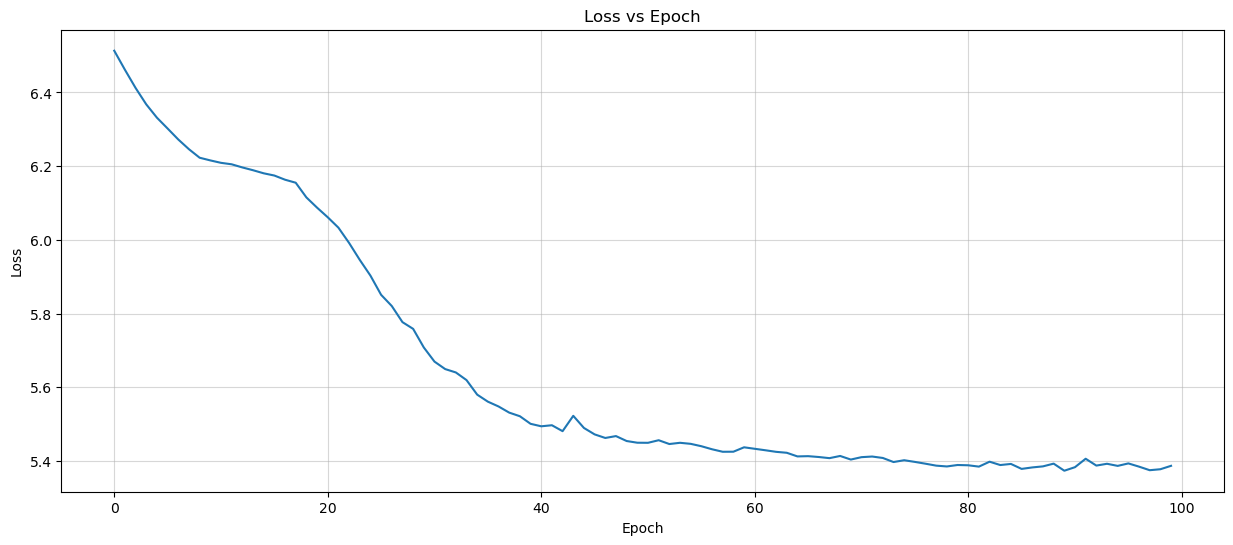

<Figure size 640x480 with 0 Axes>

In [4]:
plot_history(ckpt_path, "./train_history.png")

### Train model over the train dataset

In [5]:
eval_transforms = Transforms.Compose([
                        # Transforms.ToTensor(), # npy loader returns torch.Tensor
                        Transforms.CenterCrop(64),
                        Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                                std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
                    ])
dataloader, train_loader, val_loader, test_loader \
        = get_dataloaders(data_path="../../../input/real_lenses_dataset/", \
                          train_test_indices="../../../input/indices.pkl", \
                          state=state, eval_transforms=eval_transforms)

### Finetune the pretrained model

In [8]:
set_seed(12)

state = torch.load("./dino_vit_base_models/checkpoint.pth")
student_network = state["student"].backbone
lp_network = Classifier(mode = "finetune", backbone = copy.deepcopy(student_network))
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-7)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-9)
# scheduler = None

In [9]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 0.5632, Val Loss: 0.4255, Val Accuracy: 83.73%

[2/100] Train Loss: 0.3450, Val Loss: 0.4411, Val Accuracy: 81.15%

[3/100] Train Loss: 0.2904, Val Loss: 0.2896, Val Accuracy: 86.90%

[4/100] Train Loss: 0.2605, Val Loss: 0.3561, Val Accuracy: 86.11%

[5/100] Train Loss: 0.2575, Val Loss: 0.3767, Val Accuracy: 85.12%

[6/100] Train Loss: 0.2272, Val Loss: 0.2594, Val Accuracy: 88.49%

[7/100] Train Loss: 0.2064, Val Loss: 0.2609, Val Accuracy: 89.68%

[8/100] Train Loss: 0.1813, Val Loss: 0.2672, Val Accuracy: 88.69%

[9/100] Train Loss: 0.1561, Val Loss: 0.2668, Val Accuracy: 88.69%

[10/100] Train Loss: 0.1484, Val Loss: 0.2480, Val Accuracy: 88.69%

[11/100] Train Loss: 0.2354, Val Loss: 0.4320, Val Accuracy: 85.52%

[12/100] Train Loss: 0.3161, Val Loss: 0.2715, Val Accuracy: 89.68%

[13/100] Train Loss: 0.2152, Val Loss: 0.2353, Val Accuracy: 89.09%

[14/100] Train Loss: 0.1757, Val Loss: 0.2532, Val Accuracy: 89.29%

[15/100] Train Loss: 0.1481, Val Loss: 0.27

### Test scores when the model is run on the test dataset 

In [14]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       266        |          27         |
| true nonlenses |        15        |         285         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.9174% |
|    loss   |  0.0000  |
| auc score |  0.9785  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9466  | 0.9078 |  0.9268 |   293   |
|   nonlenses    |   0.9135  | 0.9500 |  0.9314 |   300   |
| macro averaged |   0.9300  | 0.9289 |  0.9291 |         |
+----------------+-----------+--------+---------+---------+


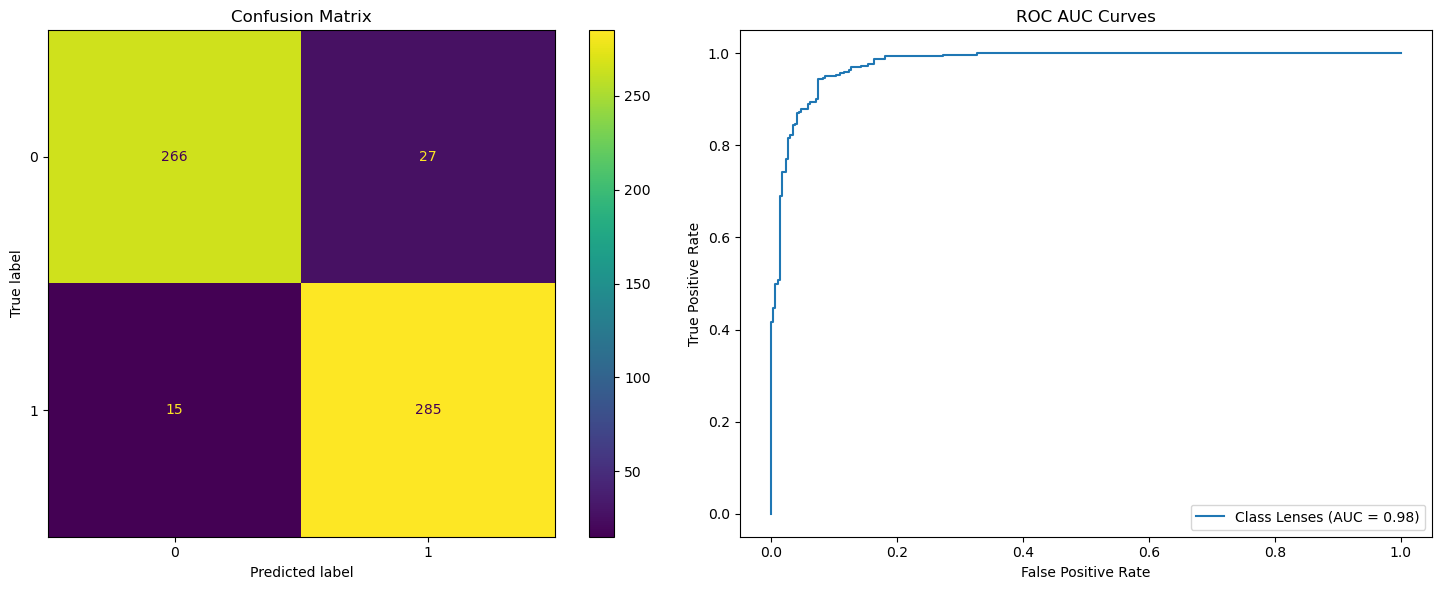

In [15]:
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [16]:
output, y_true, acc, auc = test_(lp_network, dataloader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1900       |          49         |
| true nonlenses |        37        |         1963        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.8222% |
|    loss   |  0.0052  |
| auc score |  0.9964  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9809  | 0.9749 |  0.9779 |   1949  |
|   nonlenses    |   0.9756  | 0.9815 |  0.9786 |   2000  |
| macro averaged |   0.9783  | 0.9782 |  0.9782 |         |
+----------------+-----------+--------+---------+---------+


In [17]:
with open("./classifier_network.pth", "wb") as f:
    pickle.dump(lp_network, f)